Cuaderno para resolver problema airbnb

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

from scipy import stats
from scipy.stats import norm, skew

from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline

path = '/gdrive/My Drive/Colab Notebooks/AA/data/'

In [3]:
# Hacemos la ingesta del csv
df = pd.read_csv(path+'airbnb.csv')

# Vemos los primeros datos
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11547,https://www.airbnb.com/rooms/11547,20200919153121,2020-09-21,My home at the beach,"Sun, joy, relax, quality, beach & peace.<br />...",NaN,https://a0.muscache.com/pictures/494126/8c151b...,42942,https://www.airbnb.com/users/show/42942,Daniel,2009-10-02,"Balearic Islands, Spain",.,within an hour,100%,96%,f,https://a0.muscache.com/im/users/42942/profile...,https://a0.muscache.com/im/users/42942/profile...,NaN,0.0,0.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,Calvià,NaN,39.51888,2.48182,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Oven"", ""Wifi"", ""Coffee maker"", ""Dishes and s...",$89.00,5,60,5,5,60,60,5.0,60.0,NaN,t,13,43,73,311,2020-09-21,103,8,2,2011-08-23,2020-09-06,96.0,10.0,9.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.93
1,100831,https://www.airbnb.com/rooms/100831,20200919153121,2020-09-21,HOUSE IN MALLORCA - WiFi(ET-3045),<b>The space</b><br />House situated in a quie...,NaN,https://a0.muscache.com/pictures/675527/72b329...,529151,https://www.airbnb.com/users/show/529151,Miguel,2011-04-23,Mallorca,Somos una pareja con los mismos gustos e inter...,NaN,NaN,100%,f,https://a0.muscache.com/im/users/529151/profil...,https://a0.muscache.com/im/users/529151/profil...,NaN,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,Santa Margalida,NaN,39.76347,3.16255,Entire house,Entire home/apt,8,NaN,3 baths,4.0,7.0,"[""First aid kit"", ""Hair dryer"", ""Iron"", ""Washe...",$175.00,7,365,7,7,1125,1125,7.0,1125.0,NaN,t,0,0,0,0,2020-09-21,30,13,0,2019-01-18,2020-01-25,100.0,10.0,10.0,10.0,10.0,10.0,10.0,ETV-3045,t,1,1,0,0,1.47
2,105891,https://www.airbnb.com/rooms/105891,20200919153121,2020-09-20,VILLAGE HOUSE WITH POOL: IDEAL FOR FAMILIES,The house is a street on the outskirts of the ...,The village's population does not reach two th...,https://a0.muscache.com/pictures/1036816/f36ce...,549192,https://www.airbnb.com/users/show/549192,Bartomeu,2011-05-01,"Ariany, Balearic Islands, Spain",Hola!. Resido en una casa de campo de un puebl...,within a few hours,100%,83%,t,https://a0.muscache.com/im/users/549192/profil...,https://a0.muscache.com/im/users/549192/profil...,NaN,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Maria de la Salut, Balearic Islands, Spain",Maria de la Salut,NaN,39.66044,3.07165,Entire townhouse,Entire home/apt,6,NaN,2 baths,3.0,4.0,"[""Smoke alarm"", ""Oven"", ""Wifi"", ""Garden or bac...",$140.00,6,365,6,6,365,365,6.0,365.0,NaN,t,23,53,83,325,2020-09-20,14,0,0,2012-06-19,2019-09-03,97.0,10.0,10.0,10.0,10.0,9.0,10.0,ETV/6127,t,2,2,0,0,0.14
3,106833,https://www.airbnb.com/rooms/106833,20200919153121,2020-09-20,Villa with a big pool in Mallorca,<b>The space</b><b

In [4]:
# Guardamos las características relevantes para resolución del problema
X = df[['neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'amenities']]
y = df['price']

# Vemos los primeros datos
X.head()

,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,amenities
0,Calvià,39.51888,2.48182,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,"[""Oven"", ""Wifi"", ""Coffee maker"", ""Dishes and s..."
1,Santa Margalida,39.76347,3.16255,Entire house,Entire home/apt,8,NaN,3 baths,4.0,"[""First aid kit"", ""Hair dryer"", ""Iron"", ""Washe..."
2,Maria de la Salut,39.66044,3.07165,Entire townhouse,Entire home/apt,6,NaN,2 baths,3.0,"[""Smoke alarm"", ""Oven"", ""Wifi"", ""Garden or bac..."
3,Sant Llorenç des Cardassar,39.61600,3.30121,Entire villa,Entire home/apt,4,NaN,1 bath,2.0,"[""Pool"", ""Free parking on premises"", ""Air cond..."
4,Palma de Mallorca,39.56478,2.60333,Private room in apartment,Private room,2,NaN,1 bath,1.0,"[""Pool"", ""Washer"", ""Air conditioning"", ""Kitche..."


In [5]:
X.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms
count,17608.000000,17608.000000,17608.000000,0.0,17333.000000
mean,39.657597,2.994115,5.857962,NaN,2.952980
std,0.165577,0.246129,2.727737,NaN,1.520433
min,39.301970,2.346500,0.000000,NaN,1.000000
25%,39.543433,2.796892,4.000000,NaN,2.000000
50%,39.670285,3.047310,6.000000,NaN,3.000000
75%,39.797413,3.145215,8.000000,NaN,4.000000
max,39.930650,3.475520,16.000000,NaN,40.000000


In [6]:
X.describe(include = ["O"])

,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities
count,17608,17608,17608,17600,17608
unique,53,74,4,42,15441
top,Pollença,Entire villa,Entire home/apt,2 baths,[]
freq,2268,4878,15770,5515,34


In [7]:
# Vemos el precio como está constituido
y.head()

0     $89.00
1    $175.00
2    $140.00
3    $200.00
4    $110.00
Name: price, dtype: object

In [8]:
# Vemos que el precio está constituido por un string que contiene el símbolo del dollar
# Para poderlo tratar, primero vamos a quitar el símbolo del dollar y después transformarlo en float 
y = y.apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(float)

In [9]:
# Se añade la columna de price, después de haber sido transformada
X = X.assign(price = y) 

X.head()

,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,amenities,price
0,Calvià,39.51888,2.48182,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,"[""Oven"", ""Wifi"", ""Coffee maker"", ""Dishes and s...",89.0
1,Santa Margalida,39.76347,3.16255,Entire house,Entire home/apt,8,NaN,3 baths,4.0,"[""First aid kit"", ""Hair dryer"", ""Iron"", ""Washe...",175.0
2,Maria de la Salut,39.66044,3.07165,Entire townhouse,Entire home/apt,6,NaN,2 baths,3.0,"[""Smoke alarm"", ""Oven"", ""Wifi"", ""Garden or bac...",140.0
3,Sant Llorenç des Cardassar,39.61600,3.30121,Entire villa,Entire home/apt,4,NaN,1 bath,2.0,"[""Pool"", ""Free parking on premises"", ""Air cond...",200.0
4,Palma de Mallorca,39.56478,2.60333,Private room in apartment,Private room,2,NaN,1 bath,1.0,"[""Pool"", ""Washer"", ""Air conditioning"", ""Kitche...",110.0


In [10]:
# Miramos los nulls y el porcentaje
total = X.isnull().sum().sort_values(ascending=False)
percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
bathrooms,17608,1.000000
bedrooms,275,0.015618
bathrooms_text,8,0.000454
price,0,0.000000
amenities,0,0.000000
accommodates,0,0.000000
room_type,0,0.000000
property_type,0,0.000000
longitude,0,0.000000
latitude,0,0.000000


In [11]:
# Los null los tratamos como si no tuevieran baño
X['bathrooms_text'] = X['bathrooms_text'].fillna('0 bath')
X.loc[:,'bathrooms'] = X['bathrooms_text'].apply(lambda x: 0.5 if 'half-bath' in x.lower() else float(x.split()[0]))

In [12]:
# Los null los tratamos como si tuevieran una sola habitación, ya que si es una habitación privada,
# de hotel o compartida, es una habitación y una casa o apartamento puede ser de una sola habitación
X['bedrooms'] = X['bedrooms'].fillna(1)

In [13]:
# Eliminamos la columna bathrooms, ya que no hay ningún valor
X = X.drop(['bathrooms_text'], axis=1)
# X = X.drop(['bathrooms'], axis=1)

In [14]:
#  Heating, Air conditioning, pool, beachfront
X['pool'] = X.amenities.apply(lambda x: x.replace('"','')).apply(lambda x: 1 if 'Pool' in x[1:-1].split(', ') else 0)
X['air_conditioning'] = X.amenities.apply(lambda x: x.replace('"','')).apply(lambda x: 1 if 'Air conditioning' in x[1:-1].split(', ') else 0)
# X['beachfront'] = X.amenities.apply(lambda x: x.replace('"','')).apply(lambda x: 1 if 'Beachfront' in x[1:-1].split(', ') else 0)

In [15]:
X.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,price,pool,air_conditioning
count,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000
mean,39.657597,2.994115,5.857962,2.288988,2.922478,244.383561,0.660268,0.714675
std,0.165577,0.246129,2.727737,1.363187,1.527826,409.958169,0.473632,0.451582
min,39.301970,2.346500,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,39.543433,2.796892,4.000000,1.000000,2.000000,110.000000,0.000000,0.000000
50%,39.670285,3.047310,6.000000,2.000000,3.000000,179.000000,1.000000,1.000000
75%,39.797413,3.145215,8.000000,3.000000,4.000000,275.000000,1.000000,1.000000
max,39.930650,3.475520,16.000000,32.000000,40.000000,20736.000000,1.000000,1.000000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


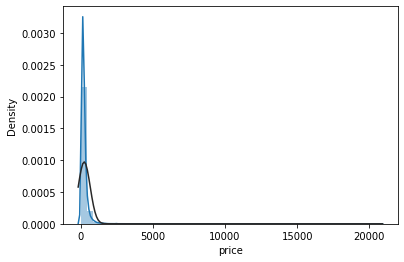

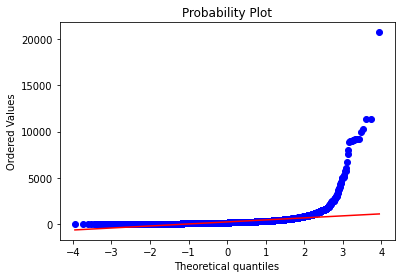

In [16]:
# Ploteamos la variable precio
sns.distplot((X['price']), fit=norm);
fig = plt.figure()
res = stats.probplot(X['price'], plot=plt)

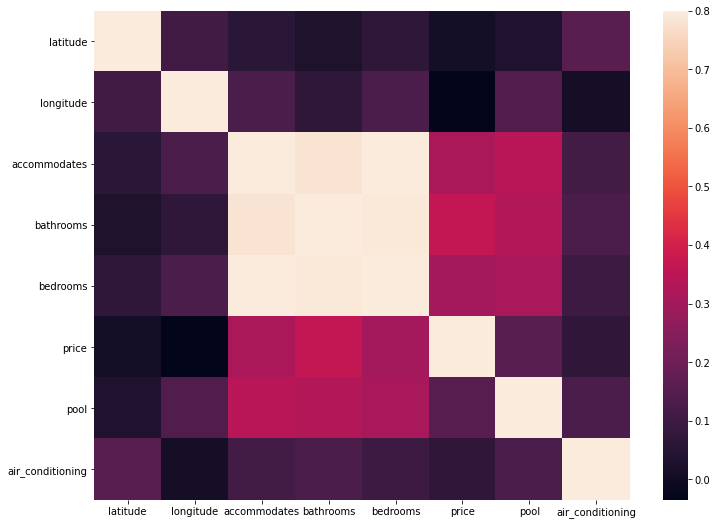

In [17]:
# correlation matrix
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(X.corr(),annot = False, vmax=.8)

Las variables que más correlacionadas con el precio son personas, baños y habitaciones.

In [18]:
X.head()

,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,amenities,price,pool,air_conditioning
0,Calvià,39.51888,2.48182,Entire apartment,Entire home/apt,2,1.0,1.0,"[""Oven"", ""Wifi"", ""Coffee maker"", ""Dishes and s...",89.0,1,1
1,Santa Margalida,39.76347,3.16255,Entire house,Entire home/apt,8,3.0,4.0,"[""First aid kit"", ""Hair dryer"", ""Iron"", ""Washe...",175.0,0,1
2,Maria de la Salut,39.66044,3.07165,Entire townhouse,Entire home/apt,6,2.0,3.0,"[""Smoke alarm"", ""Oven"", ""Wifi"", ""Garden or bac...",140.0,1,1
3,Sant Llorenç des Cardassar,39.61600,3.30121,Entire villa,Entire home/apt,4,1.0,2.0,"[""Pool"", ""Free parking on premises"", ""Air cond...",200.0,1,1
4,Palma de Mallorca,39.56478,2.60333,Private room in apartment,Private room,2,1.0,1.0,"[""Pool"", ""Washer"", ""Air conditioning"", ""Kitche...",110.0,1,1


In [19]:
# Dataframe para realizar la predicción, donde eliminamos las coordenas, el tipo de propiedad y las amenities
X_aux = X.drop(['latitude', 'longitude', 'property_type', 'amenities'], axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


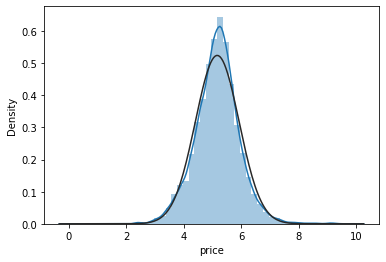

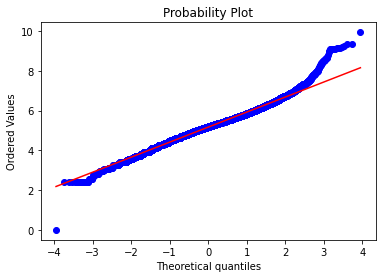

In [20]:
# Ploteamos el precio después de aplicar una transformación logarítmica
sns.distplot((np.log1p(X_aux.price)), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log1p(X_aux.price), plot=plt)

Vemos que se ajusta más a la pendiente del precio.

In [21]:
X_aux.describe()

,accommodates,bathrooms,bedrooms,price,pool,air_conditioning
count,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000,17608.000000
mean,5.857962,2.288988,2.922478,244.383561,0.660268,0.714675
std,2.727737,1.363187,1.527826,409.958169,0.473632,0.451582
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,4.000000,1.000000,2.000000,110.000000,0.000000,0.000000
50%,6.000000,2.000000,3.000000,179.000000,1.000000,1.000000
75%,8.000000,3.000000,4.000000,275.000000,1.000000,1.000000
max,16.000000,32.000000,40.000000,20736.000000,1.000000,1.000000


Creamos nuestro custom transformer

In [22]:
### Transformer custom

class SelectColumns(TransformerMixin):
    def __init__(self, columns: list) -> pd.DataFrame:
        if not isinstance(columns, list):
            raise ValueError('Specify the columns into a list')
        self.columns = columns
    def fit(self, X, y=None): # we do not need to specify the target in the transformer. We leave it as optional arg for consistency
        return self
    def transform(self, X):
        return X[self.columns]
    
class DropColumns(TransformerMixin):
    def __init__(self, columns: list) -> pd.DataFrame:
        if not isinstance(columns, list):
            raise ValueError('Specify the columns into a list')
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(self.columns, axis=1)

Seleccionamos las variables categóricas y le aplicamos one hot encoding

In [23]:
select_col_step = ('select', SelectColumns(['neighbourhood_cleansed', 'room_type']))

one_hot_step_neighbourhood = ('neighbourhood_one_hot', OneHotEncoder(sparse=False))
one_hot_step_room = ('room_one_hot', OneHotEncoder(sparse=False))

cat_pipe_steps = [select_col_step, one_hot_step_neighbourhood, one_hot_step_room]

cat_pipe = Pipeline(cat_pipe_steps)

Ahora aplicamos una transformación polinomial y estandarizamos los datos

In [24]:
drop_column_step = ('drop_column', DropColumns(['neighbourhood_cleansed', 'room_type']))
# drop_column_step = ('drop_column', DropColumns(['neighbourhood_cleansed', 'room_type', 'pool', 'air_conditioning']))

poly_step = ('poly', PolynomialFeatures(2,  interaction_only=True))

scaler_step = ('scaler', StandardScaler())

num_pipe_steps = [drop_column_step, poly_step, scaler_step]

num_pipe = Pipeline(num_pipe_steps)

Unimos la transformación de las variables categóricas y numéricas

In [25]:
transformer_list = [('num_pipe', num_pipe),
                    ('cat_pipe', cat_pipe)]

full_pipe = FeatureUnion(transformer_list=transformer_list)

In [26]:
# Separamos entre datos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_aux.drop(['price'], axis=1), np.log1p(X_aux.price), test_size=0.2)

In [27]:
# Instanciamos el modelo
reg = RandomForestRegressor(max_depth=100)

In [28]:
# Transformamos los datos de entrenamiento
X_train_trans = full_pipe.fit_transform(X_train)

In [29]:
# Entrenamos el modelo
reg.fit(X_train_trans, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [30]:
# Realizamos la predicción tanto con los datos de entrenamiento como con los de test, para después compararlos
y_train_pred_pipe = reg.predict(X_train_trans)
y_test_pred_pipe = reg.predict(full_pipe.transform(X_test))

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('Mean absolute error: {e} $'.format(e=round(mean_absolute_error(y_test, y_test_pred_pipe), 2)))

Mean absolute error: 0.35 $


In [32]:
def RMSE(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

in_sample_error = RMSE(y_train, y_train_pred_pipe)
out_sample_error = RMSE(y_test, y_test_pred_pipe)

print('In sample error: {e} $'.format(e=round(in_sample_error, 2)))
print('In sample error: {e} $'.format(e= round(out_sample_error, 2)))

In sample error: 0.37 $
In sample error: 0.48 $


In [33]:
bins = y_test.unique().shape[0]

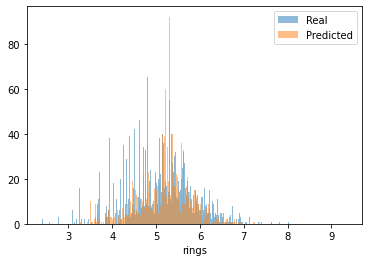

In [34]:
plt.hist(y_test, alpha=0.5, bins=bins, label='Real')
plt.hist(y_test_pred_pipe, alpha=0.5, bins=bins, label='Predicted')
plt.xlabel('rings')
plt.legend(loc='best')
plt.show()

Text(0, 0.5, 'Predicted Value')

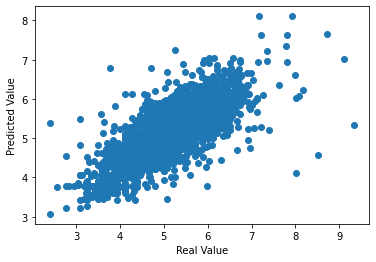

In [35]:
f, ax = plt.subplots()

ax.scatter(y_test, y_test_pred_pipe)
ax.set_xlabel('Real Value')
ax.set_ylabel('Predicted Value')